In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz

# Data pre-processing

In [3]:
#importing the dataframe
df = pd.read_csv('spotify-2023.csv', sep = ',', header = 0 , encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [4]:
# Checking dataframe size
df.shape

(953, 24)

There are 24 features and 953 observations in this dataframe

**Handling missing values and data type**

In [5]:
#Cheking if there is any missing value
df.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

There are missing values in the 'in_shazam_charts' and the 'key' columns. 
- As the song might not never be appearing on the shazam chart, this will result in null values. To handle these missing values, we will fill in the missing data in 'in_shazam_charts' column with value '0'.
- As every song has a key, there can not be null values in the 'key' column. To handle these misisng values, we will fill in the missing data in 'key' column with value '-', since any random assign for 'key' might be wrong.


In [6]:
#Dropping missing values
df.fillna({'in_shazam_charts': 0, 'key': '-'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      953 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   953 non-null    ob

There is no null value now

As the released_day feature is of no value, we will drop this column

In [7]:
#Dropping released_day column
df = df.drop('released_day', axis = 1)
df.shape

(953, 23)

In [8]:
#Checking variables type
df.dtypes

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

As we can see, the "streams", "in_deezer_playlists and "in_shazam_charts" have the object dtype. For effective ranking and calculation, we will convert those dtype column to 'int' dtype

In [9]:
#convert object dtype to numeric dtype
df.loc[:,['streams','in_deezer_playlists','in_shazam_charts']] = df[['streams','in_deezer_playlists','in_shazam_charts']].apply(pd.to_numeric,errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   in_spotify_playlists  953 non-null    int64 
 6   in_spotify_charts     953 non-null    int64 
 7   streams               952 non-null    object
 8   in_apple_playlists    953 non-null    int64 
 9   in_apple_charts       953 non-null    int64 
 10  in_deezer_playlists   874 non-null    object
 11  in_deezer_charts      953 non-null    int64 
 12  in_shazam_charts      946 non-null    object
 13  bpm                   953 non-null    int64 
 14  key                   953 non-null    object
 15  mode                  953 non-null    ob

As there are non-numeric values in the 'streams', 'in_deezer_playlists', and 'in_shazam_charts', those values were converted to null values. Firstly, we have to drop these null values. Next, we can convert object dtype to int dtype using 'astype' function

In [10]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 867 entries, 0 to 952
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            867 non-null    object
 1   artist(s)_name        867 non-null    object
 2   artist_count          867 non-null    int64 
 3   released_year         867 non-null    int64 
 4   released_month        867 non-null    int64 
 5   in_spotify_playlists  867 non-null    int64 
 6   in_spotify_charts     867 non-null    int64 
 7   streams               867 non-null    object
 8   in_apple_playlists    867 non-null    int64 
 9   in_apple_charts       867 non-null    int64 
 10  in_deezer_playlists   867 non-null    object
 11  in_deezer_charts      867 non-null    int64 
 12  in_shazam_charts      867 non-null    object
 13  bpm                   867 non-null    int64 
 14  key                   867 non-null    object
 15  mode                  867 non-null    object


The dataframe now has 867 observations

In [11]:
#Converting object dtype to int dtype
df = df.astype({"streams": int, "in_deezer_playlists": int, "in_shazam_charts": int}, errors = 'ignore')
df.dtypes

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                  int64
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists      int64
in_deezer_charts         int64
in_shazam_charts         int64
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

**Summary of statistics**

In [12]:
df.describe()


,artist_count,released_year,released_month,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,867.000000,867.000000,867.000000,867.000000,867.000000,8.670000e+02,867.00000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,1.574394,2019.223760,6.152249,3371.915802,10.807382,4.058458e+08,54.33218,48.294118,109.200692,2.463668,46.572088,123.061130,67.261822,51.508651,64.131488,27.366782,1.606690,18.366782,10.326413
std,0.913051,10.570264,3.508798,4042.566785,18.111052,4.093741e+08,64.91117,48.666704,178.159888,5.643325,120.090364,28.194265,14.452341,23.462138,16.385970,25.695574,8.523902,13.915838,10.051750
min,1.000000,1930.000000,1.000000,31.000000,0.000000,2.762000e+03,0.00000,0.000000,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2021.000000,3.000000,817.500000,0.000000,1.352617e+08,12.00000,6.000000,12.000000,0.000000,0.000000,100.000000,58.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,1930.000000,2.000000,2.587147e+08,29.00000,32.000000,36.000000,0.000000,1.000000,121.000000,70.000000,52.000000,65.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,4280.500000,15.000000,5.314238e+08,72.00000,81.000000,110.000000,2.000000,30.000000,142.000000,78.000000,70.000000,76.500000,43.000000,0.000000,24.000000,12.000000
max,8.000000,2023.000000,12.000000,29499.000000,147.000000,2.808097e+09,492.00000,275.000000,974.000000,46.000000,953.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


# Visualization

**Histogram**

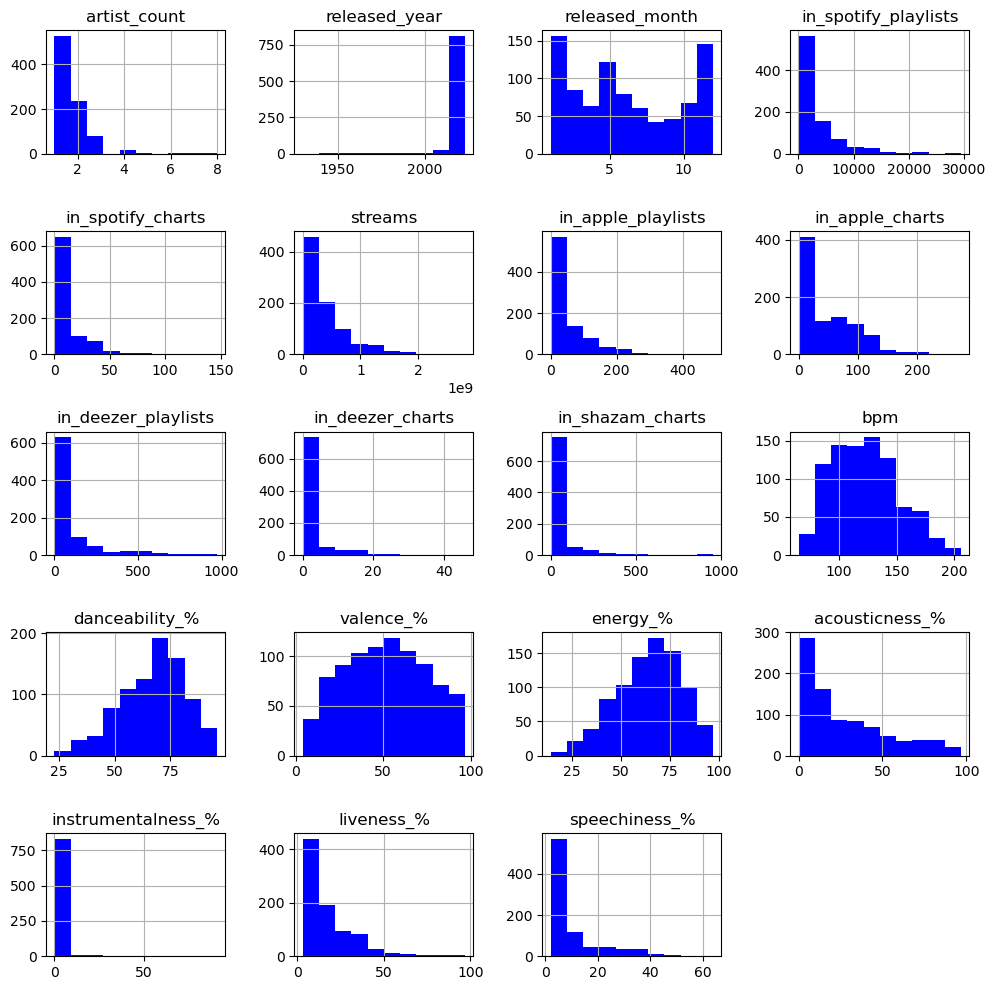

In [13]:
df.hist(figsize = (10,10), color = 'blue')
plt.tight_layout()

We can use a heatmap to explore patterns in audio features

**Correlation heatmap**

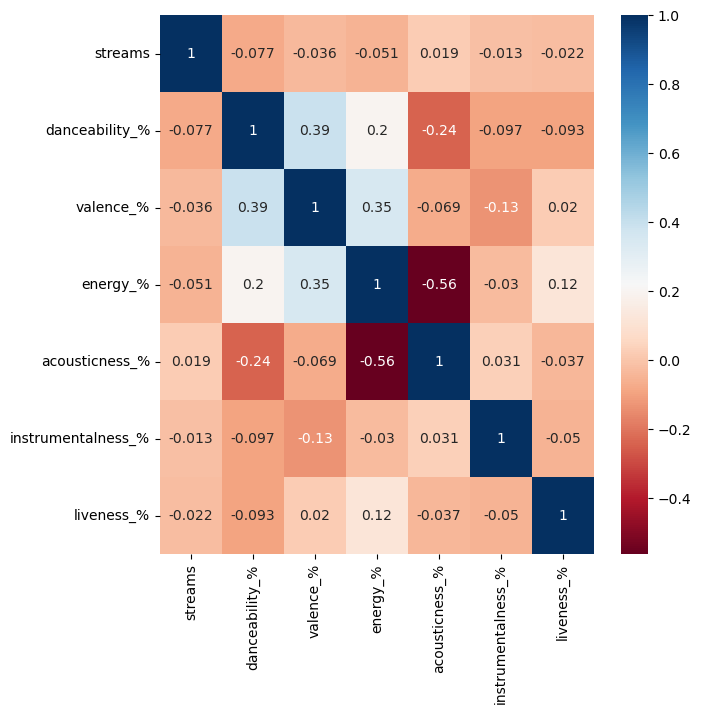

In [14]:
plt.figure(figsize = (7,7))
sns.heatmap(df[['streams','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%']].corr(), annot=True,cmap='RdBu')
plt.show()

According to the map, the percentage indicating how suitable the song is for dancing and the total number of streams have a relatively negative correlation. Meanwhile, the amount of acoustic sound in the song positively correlates with the total number of streams on Spotify. Other factors have little influence on the number of streams.

**Time series plot**

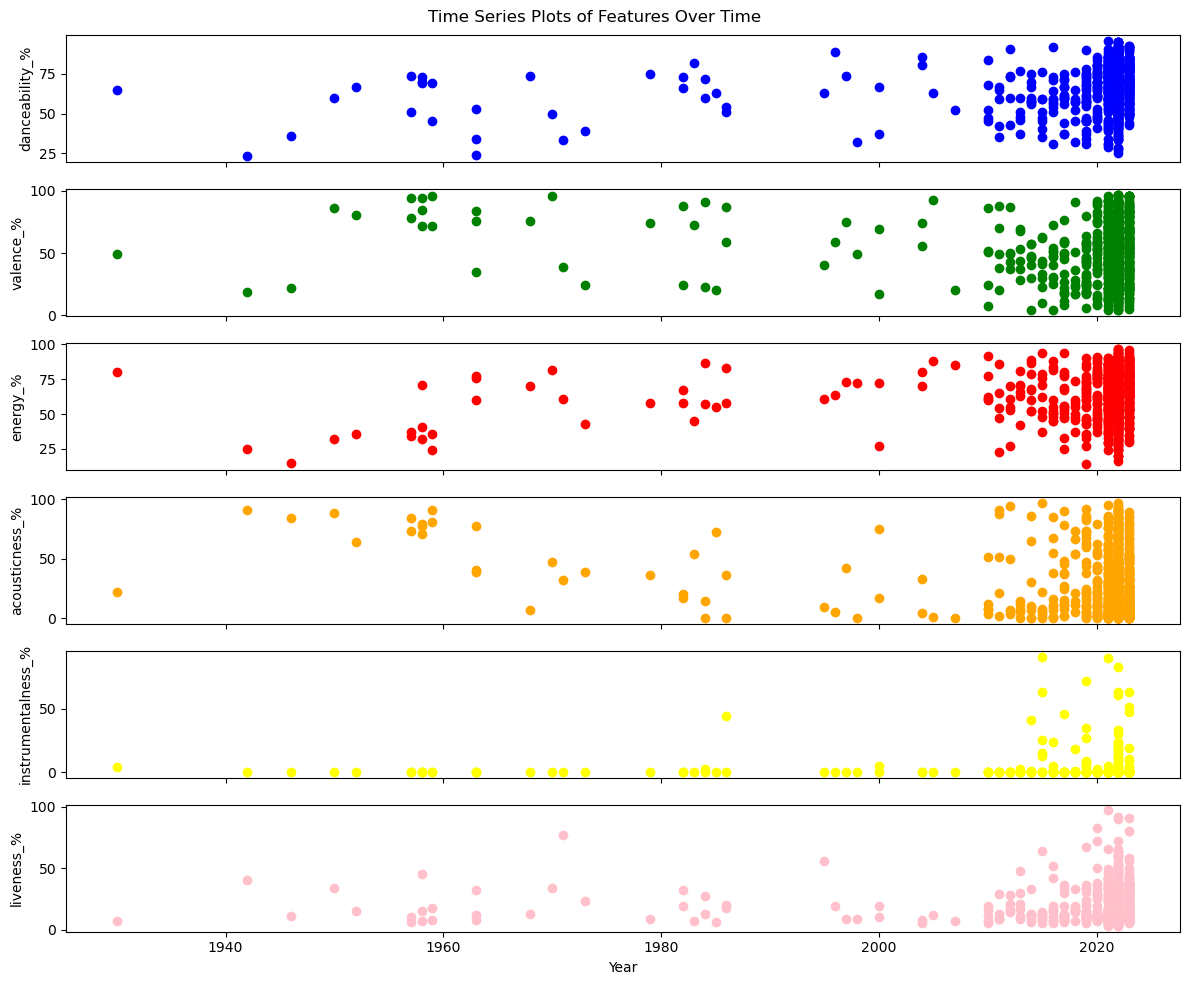

In [15]:
# Create subplots for each feature
fig, axs = plt.subplots(nrows=6, figsize=(12, 10), sharex=True)

# Plot 'danceability_%'
axs[0].scatter(df['released_year'], df['danceability_%'], label='danceability_%', color='blue')
axs[0].set_ylabel('danceability_%')

# Plot 'valence_%'
axs[1].scatter(df['released_year'], df['valence_%'], label='valence_%', color='green')
axs[1].set_ylabel('valence_%')

                  
# Plot 'energy_%'
axs[2].scatter(df['released_year'], df['energy_%'], label='energy_%', color='red')
axs[2].set_ylabel('energy_%')

# Plot 'acousticness_%'
axs[3].scatter(df['released_year'], df['acousticness_%'], label='acousticness_%', color='orange')
axs[3].set_ylabel('acousticness_%')


# Plot 'instrumentalness_%'
axs[4].scatter(df['released_year'], df['instrumentalness_%'], label='instrumentalness_%', color='yellow')
axs[4].set_ylabel('instrumentalness_%')

# Plot 'liveness_%
axs[5].scatter(df['released_year'], df['liveness_%'], label='liveness_%', color='pink')
axs[5].set_ylabel('liveness_%')
                

plt.xlabel('Year')
plt.suptitle('Time Series Plots of Features Over Time')
plt.tight_layout()
plt.show()

# Exploratory analysis

### Clustering

As part of exploratory analysis, to find hidden patterns or groupings in data, we will use clustering, a type of unsupervised learning which is used to group similar instances into clusters based on their feature values. 

In [16]:
sse = []
k_rng = range(1,10)
features = df[['danceability_%','energy_%','liveness_%','valence_%','instrumentalness_%','acousticness_%']]
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(features)
    sse.append(km.inertia_)

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/software/lib/python3.10/site-packages/sklearn/clust

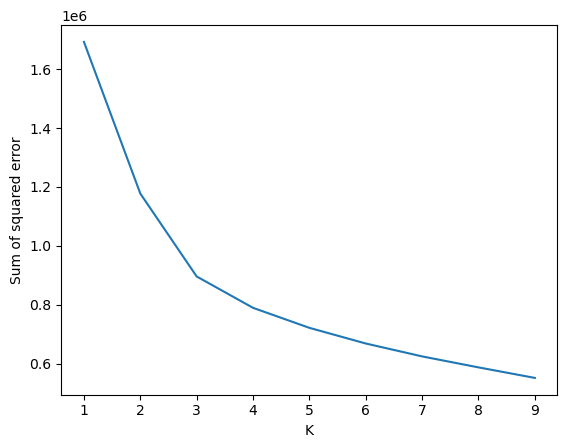

In [17]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [18]:
# Select audio features and popularity metrics for clustering
features = df[['danceability_%', 'energy_%', 'liveness_%','valence_%','instrumentalness_%','acousticness_%']]

# Apply KMeans clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(features_scaled)

# Add the cluster labels to the original dataframe
df['cluster'] = kmeans.labels_
print(df)

                              track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     released_year  released_month  in_spotify_playlists  in_sp

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
km.cluster_centers_

array([[6.10434783e+01, 6.48768116e+01, 1.72536232e+01, 2.48913043e+01,
        5.79710145e-01, 7.75362319e+00],
       [7.46521739e+01, 6.67391304e+01, 1.70608696e+01, 7.61130435e+01,
        2.26086957e-01, 4.10347826e+01],
       [4.94000000e+01, 3.78142857e+01, 1.62285714e+01, 2.35428571e+01,
        2.98571429e+00, 7.67142857e+01],
       [6.37758621e+01, 7.58965517e+01, 5.25862069e+01, 5.35172414e+01,
        1.72413793e-02, 1.55172414e+01],
       [7.38235294e+01, 7.66911765e+01, 1.73235294e+01, 7.96250000e+01,
        3.38235294e-01, 9.40441176e+00],
       [6.36666667e+01, 5.48222222e+01, 1.61444444e+01, 3.29444444e+01,
        1.35555556e+00, 3.88111111e+01],
       [5.76666667e+01, 6.72500000e+01, 1.40000000e+01, 3.26666667e+01,
        6.19166667e+01, 1.70000000e+01],
       [6.46825397e+01, 4.72380952e+01, 1.57619048e+01, 6.11746032e+01,
        9.68253968e-01, 7.32222222e+01],
       [7.35837838e+01, 6.90702703e+01, 1.31081081e+01, 5.23135135e+01,
        5.67567568e-01, 

In [20]:
# Calculate WSS
wss = kmeans.inertia_

# Calculate Silhouette Score
silhouette = silhouette_score(features_scaled, kmeans.labels_)

print('Within-cluster Sum of Squares (WSS):', wss)
print('Silhouette Score:', silhouette)

Within-cluster Sum of Squares (WSS): 4077.480852967968
Silhouette Score: 0.28153484672900164


In [21]:
print(df['cluster'].value_counts())

cluster
0    621
1    246
Name: count, dtype: int64


### Clustering, results

/tmp/ipykernel_465/3334674616.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['danceability_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


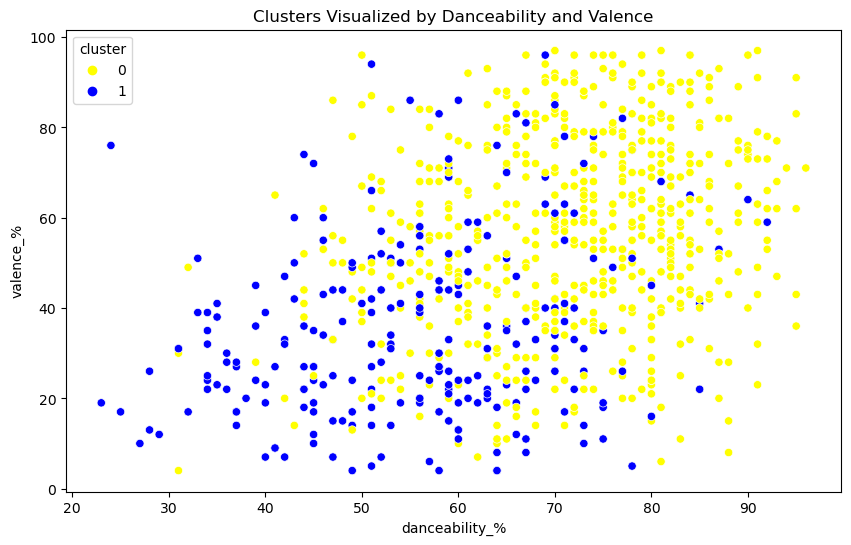

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Danceability and Valence')
plt.show()

/tmp/ipykernel_465/927131256.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['danceability_%'], y=df['energy_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


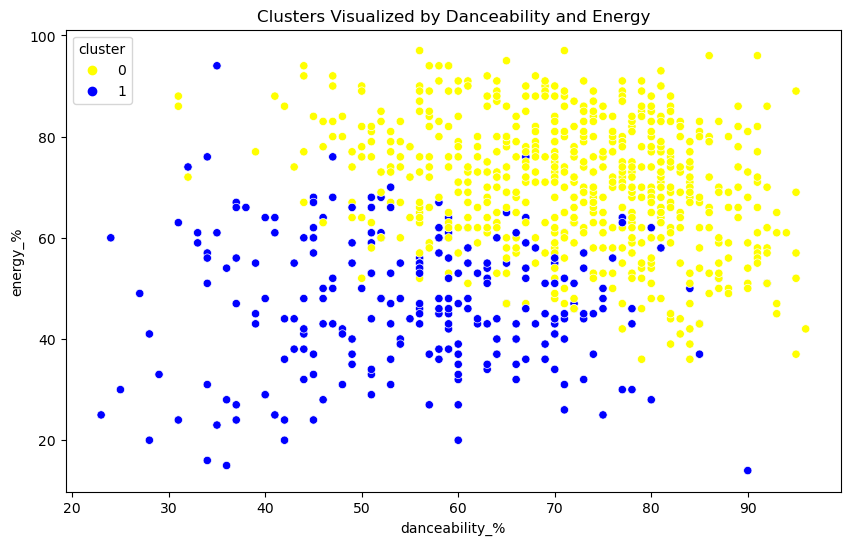

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability_%'], y=df['energy_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Danceability and Energy')
plt.show()

/tmp/ipykernel_465/1109232588.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['danceability_%'], y=df['liveness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


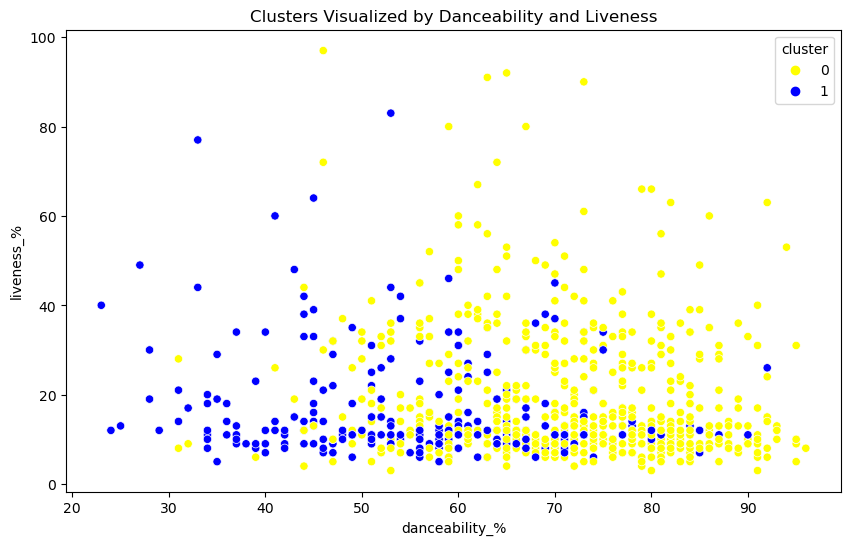

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability_%'], y=df['liveness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Danceability and Liveness')
plt.show()

/tmp/ipykernel_465/2818231146.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['danceability_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


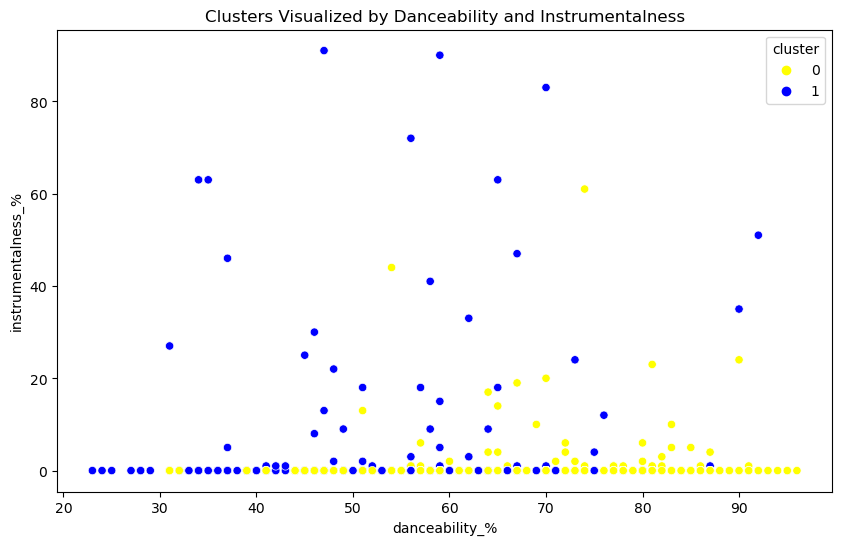

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Danceability and Instrumentalness')
plt.show()

/tmp/ipykernel_465/4156932636.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['danceability_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


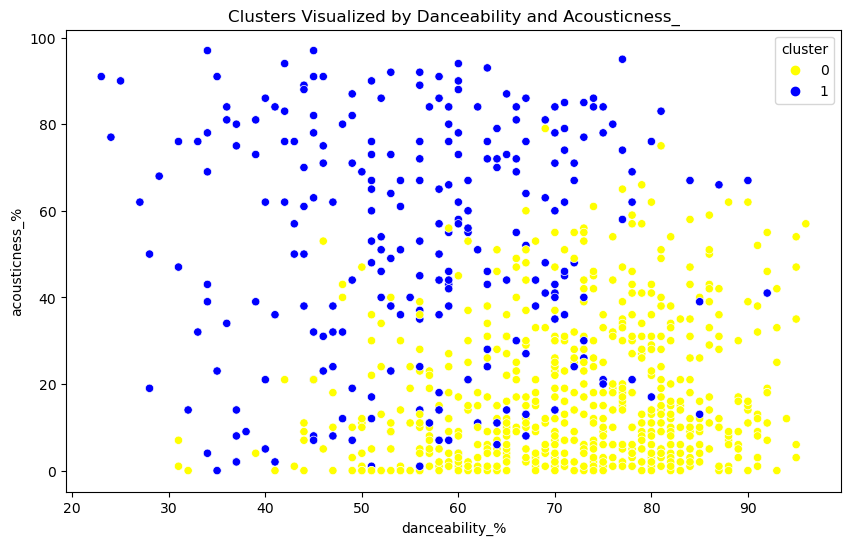

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Danceability and Acousticness_')
plt.show()

/tmp/ipykernel_465/1269990010.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['energy_%'], y=df['liveness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


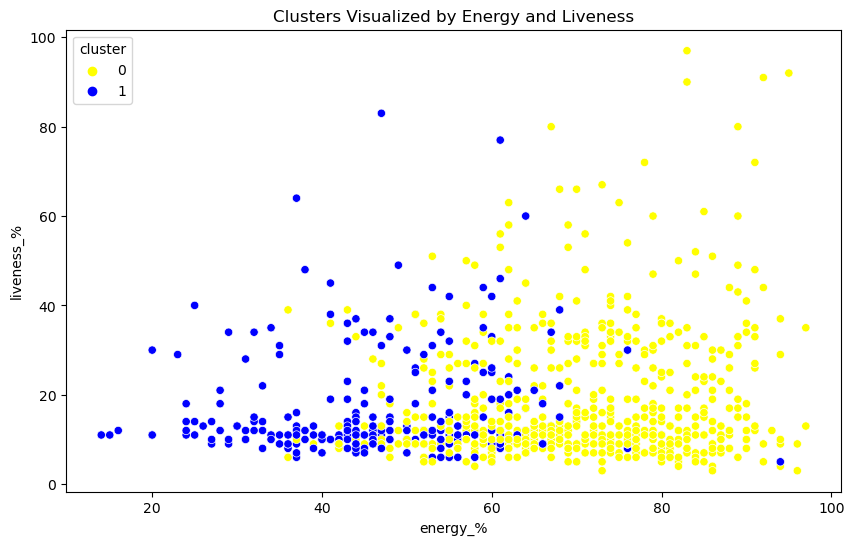

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['energy_%'], y=df['liveness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Energy and Liveness')
plt.show()

/tmp/ipykernel_465/32387686.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['energy_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


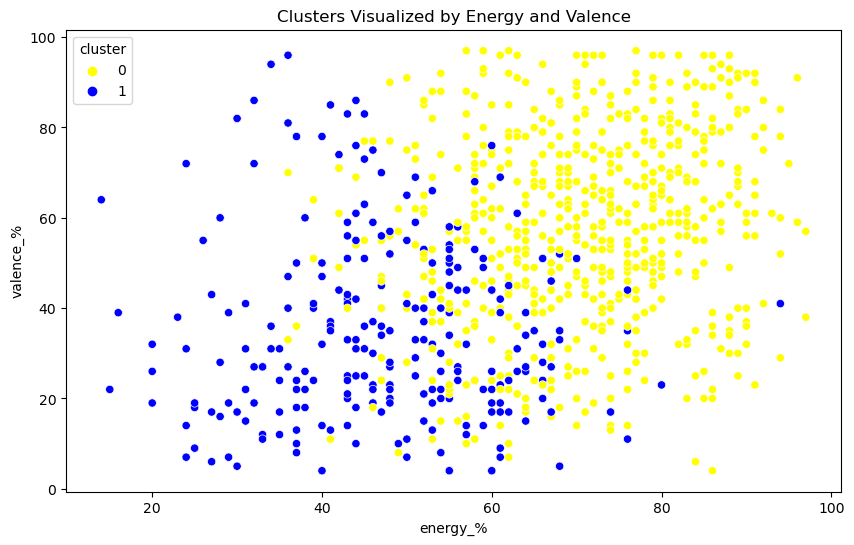

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['energy_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Energy and Valence')
plt.show()

/tmp/ipykernel_465/2316308654.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['energy_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


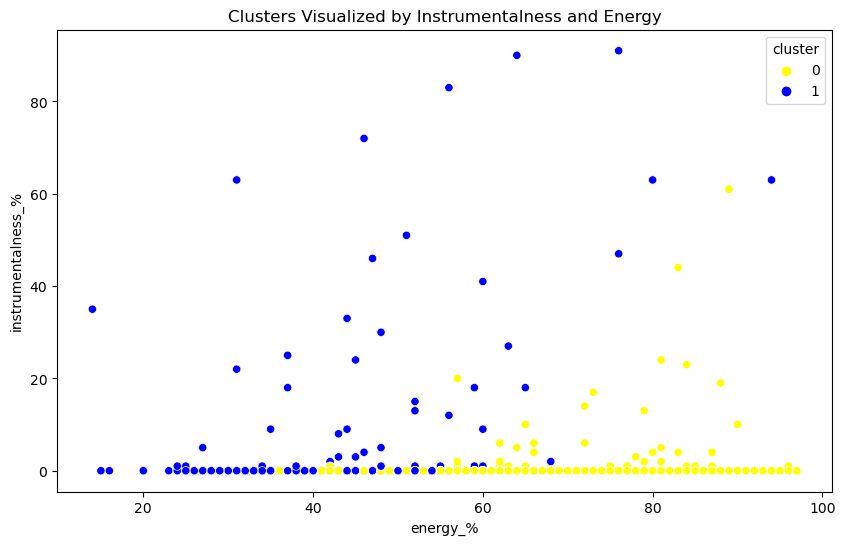

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['energy_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Instrumentalness and Energy')
plt.show()

/tmp/ipykernel_465/1178753326.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['energy_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


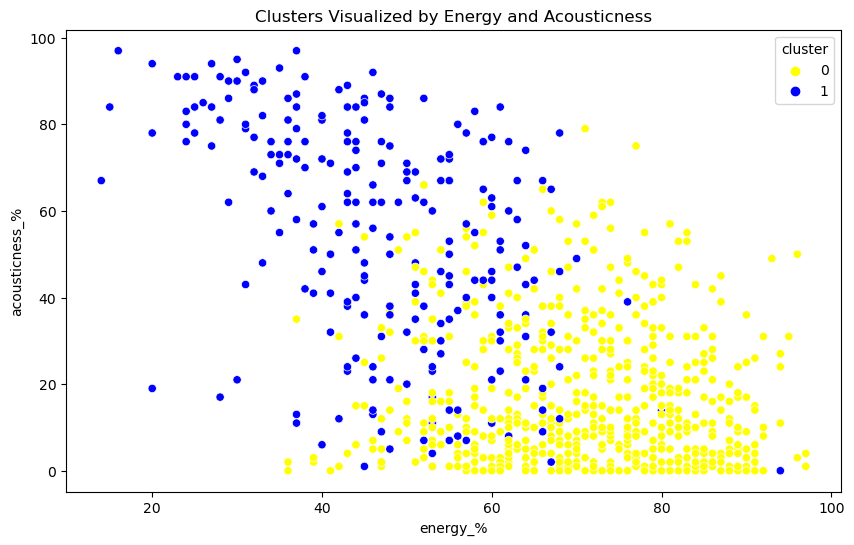

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['energy_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Energy and Acousticness')
plt.show()

/tmp/ipykernel_465/1661142766.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['liveness_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


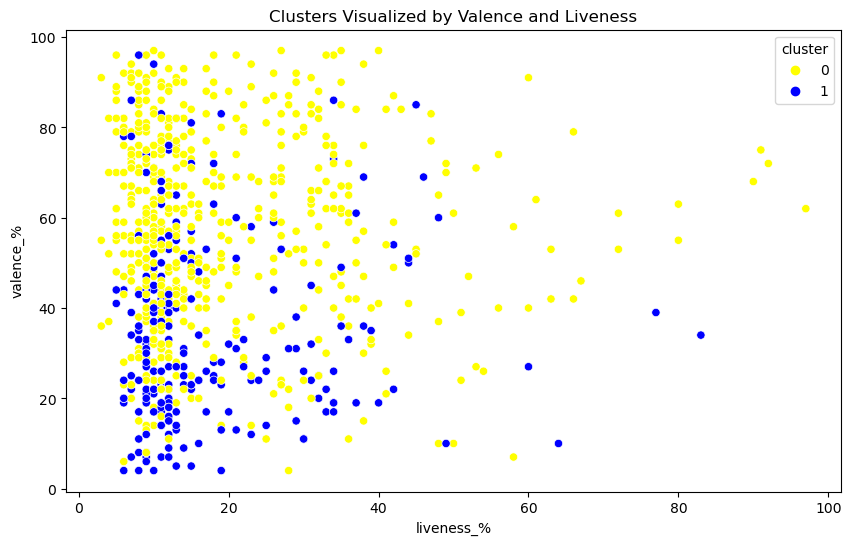

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['liveness_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Valence and Liveness')
plt.show()

/tmp/ipykernel_465/1074728921.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['liveness_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


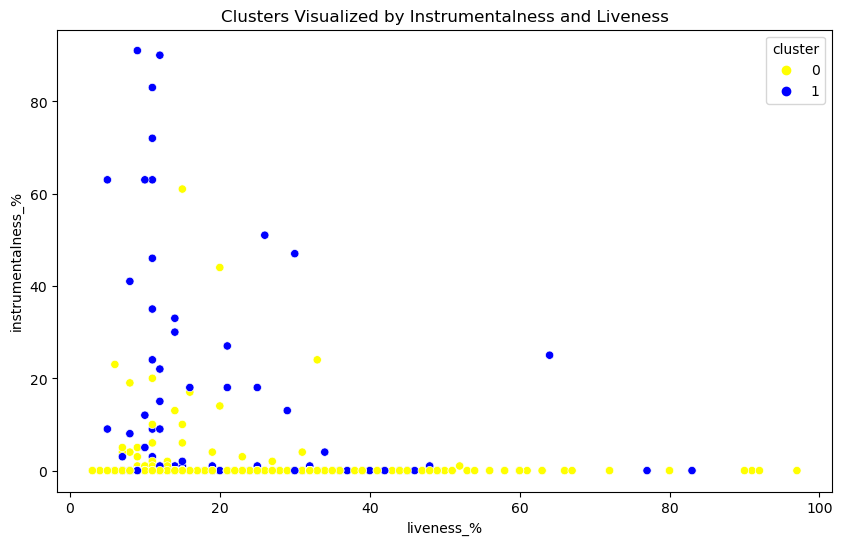

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['liveness_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Instrumentalness and Liveness')
plt.show()

/tmp/ipykernel_465/3822695182.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['liveness_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


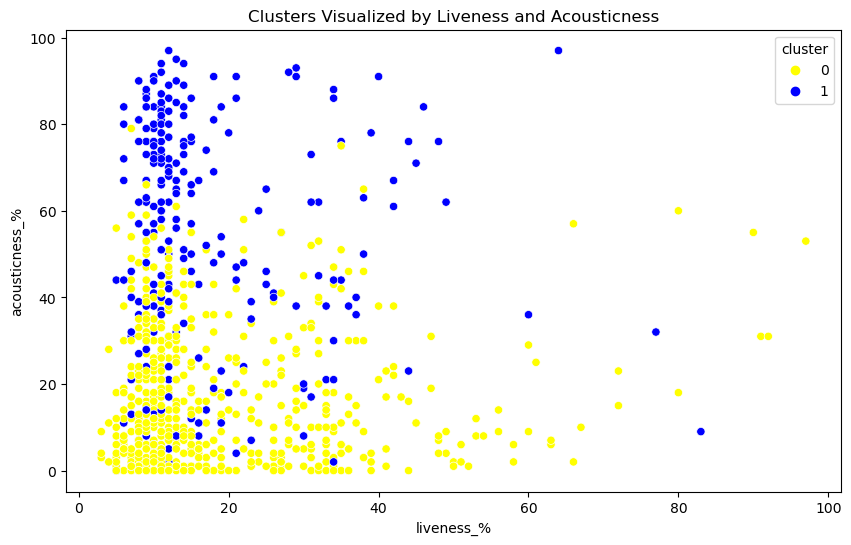

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['liveness_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Liveness and Acousticness')
plt.show()

/tmp/ipykernel_465/690831194.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['instrumentalness_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


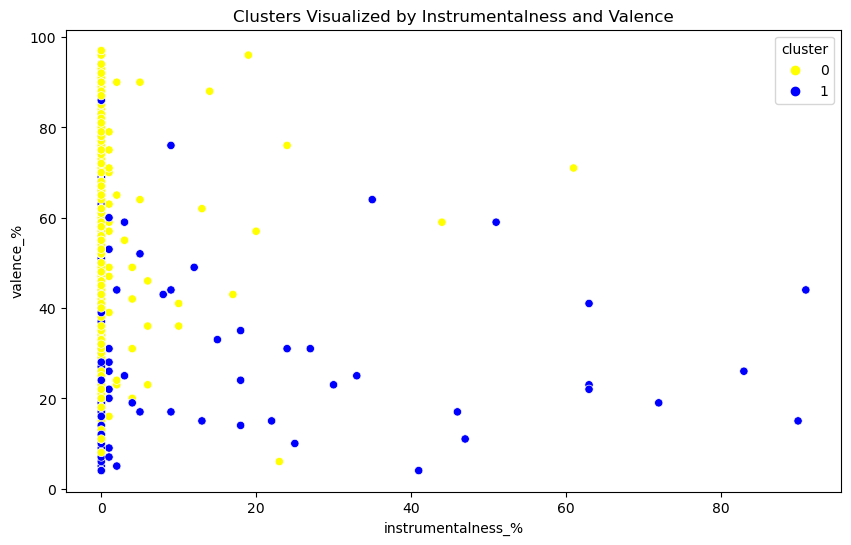

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['instrumentalness_%'], y=df['valence_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Instrumentalness and Valence')
plt.show()

/tmp/ipykernel_465/609177356.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['valence_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


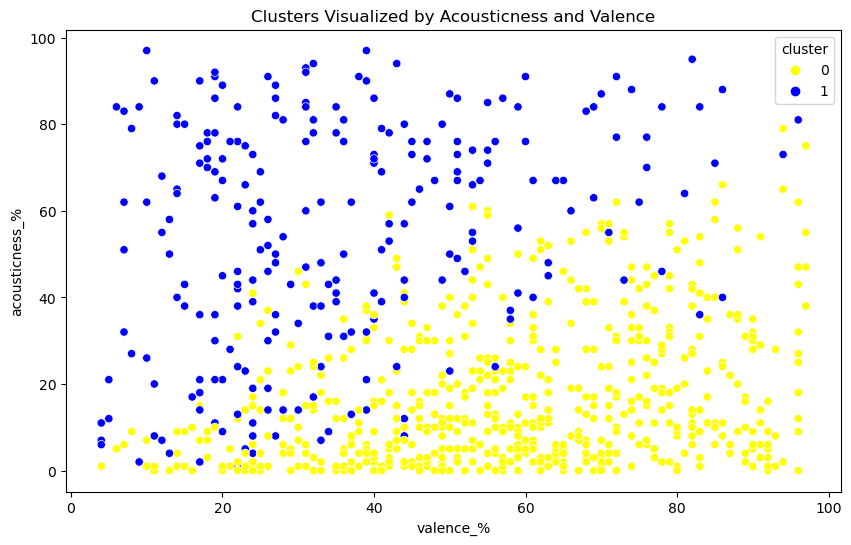

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['valence_%'], y=df['acousticness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Acousticness and Valence')
plt.show()

/tmp/ipykernel_465/3703729830.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=df['acousticness_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])


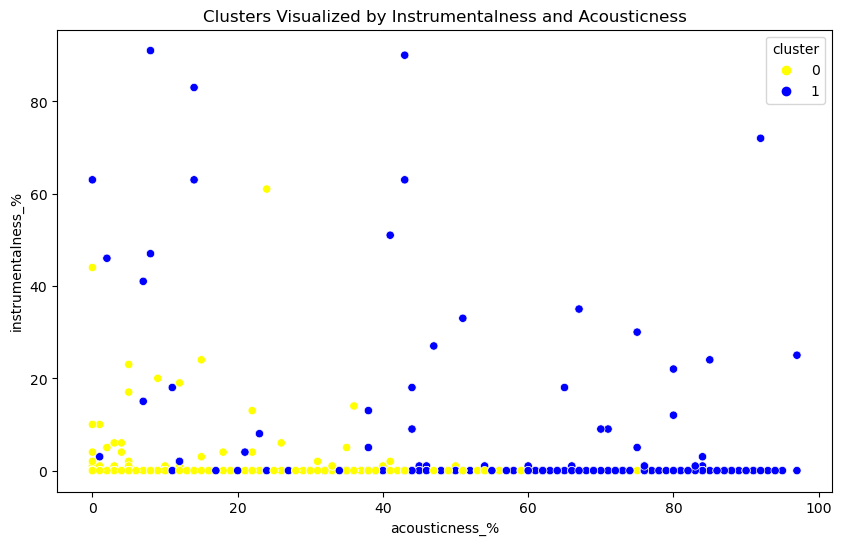

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['acousticness_%'], y=df['instrumentalness_%'], hue=df['cluster'], palette=['yellow', 'blue', 'red'])
plt.title('Clusters Visualized by Instrumentalness and Acousticness')
plt.show()

### What songs are more popular on Spotify?

Firstly, let's figure out the total number of streams for each cluster.

In [37]:
# Total number of streams for each cluster
streams_per_cluster = df.groupby('cluster')['streams'].sum()
print(streams_per_cluster)

cluster
0    245523987161
1    106344287271
Name: streams, dtype: int64


In [38]:
for index, row in df.iterrows():
    if row['cluster'] == 1:
        print(row['track_name'])

vampire
WHERE SHE GOES
I Wanna Be Yours
Last Night
Creepin'
TQG
See You Again
Die For You - Remix
cardigan
BESO
People
Enchanted (Taylor's Version)
golden hour
Here With Me
Until I Found You (with Em Beihold) - Em Beihold Version
Novidade na ï¿½ï¿
Donï¿½ï¿½ï¿½t Bl
Still With You
Say Yes To Heaven
Snooze
Lover
Primera Cita
Tak Segampang Itu
august
Calling (Spider-Man: Across the Spider-Verse) (Metro Boomin & Swae Lee, NAV, feat. A Boogie Wit da Hoodie)
Romantic Homicide
Novo Balanï¿½
Stargirl Interlude
Those Eyes
Enchanted
The Night We Met
When I Was Your Man
Let Me Down Slowly
Am I Dreaming (Metro Boomin & A$AP Rocky, Roisee)
Night Changes
Car's Outside
Apocalypse
Pink + White
Shut up My Moms Calling
Annihilate (Spider-Man: Across the Spider-Verse) (Metro Boomin & Swae Lee, Lil Wayne, Offset)
Acrï¿½ï¿½s
Phir Aur Kya Chahiye (From "Zara Hatke Zara Bachke")
Self Love (Spider-Man: Across the Spider-Verse) (Metro Boomin & Coi Leray)
Abcdario
Snow On The Beach (feat. More Lana Del Rey)
Humm

In absolute terms, songs from the cluster 0 are the most streamed. To understand cluster popularity better, we will calculate the average number of streams per song for each cluster.

In [39]:
# Calculate total streams per cluster
total_streams_per_cluster = df.groupby('cluster')['streams'].sum()

# Calculate number of songs per cluster
songs_per_cluster = df['cluster'].value_counts()

# Calculate average streams per song for each cluster
average_streams_per_song = total_streams_per_cluster / songs_per_cluster

print(average_streams_per_song)


cluster
0    3.953687e+08
1    4.322939e+08
dtype: float64


Since a higher average indicates that songs within that cluster are streamed more frequently on average, **songs from cluster 1** (calm, not necessarily made for dancing, more melancholic, more vocal, acoustic, and likely studio-recorded) **are the most listened songs on Spotify**. 

### Conclusions, clustering analysis

In [40]:
grouped = df.groupby('cluster')

popularity_means = grouped[['streams','in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists','in_apple_charts','in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts']].mean()
print(popularity_means)

              streams  in_spotify_playlists  in_spotify_charts  \
cluster                                                          
0        3.953687e+08           3269.892110          11.806763   
1        4.322939e+08           3629.463415           8.284553   

         in_apple_playlists  in_apple_charts  in_deezer_playlists  \
cluster                                                             
0                 57.940419        50.795491           106.438003   
1                 45.223577        41.979675           116.174797   

         in_deezer_charts  in_shazam_charts  
cluster                                      
0                2.822866          51.94847  
1                1.556911          33.00000  


Songs from cluster 0 do appear in the charts most often across all platforms (Spotify, Apple Music, Deezer, and Shazam). This suggests that these songs are currently trending or popular.

However, when it comes to inclusion in playlists, the logic seems to differ. On Spotify, songs from cluster 1 are included in the highest average number of playlists. On Apple, songs from cluster 0 are included in the highest average number of playlists. Lastly, on  Deezer, songs from cluster 1 are included in the highest average number of playlists. 
This could indicate that while these songs might not be chart-toppers, they are consistently included in a variety of playlists, suggesting a broad appeal or suitability for different moods, activities, or genres. Also, since songs from different clusters are included in the highest number of playlists, we believe that it shows differences in users on different platforms. 

Interestingly, Spotify does have the highest number of playlists. This could be due to a variety of factors such as user base size, platform features, or user behavior patterns.

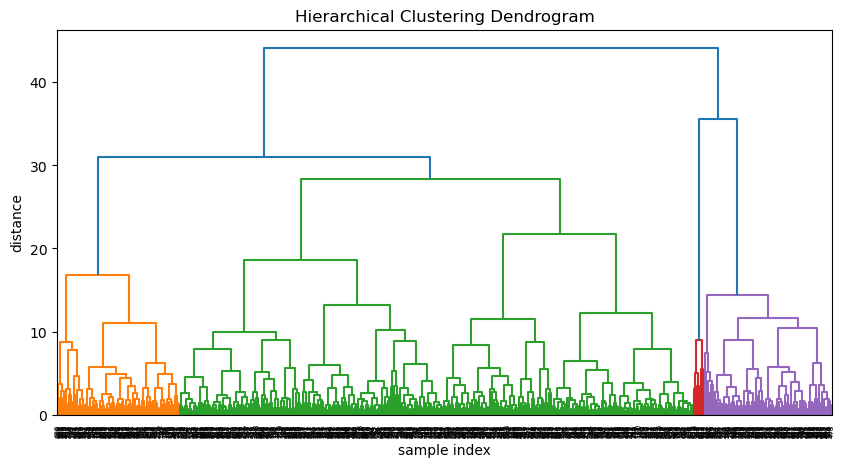

In [41]:
# Select features for clustering
features = df[['danceability_%','energy_%','liveness_%','valence_%','instrumentalness_%','acousticness_%']]

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Generate the linkage matrix using 'ward' method (minimizes the variance of the clusters being merged)
x = linkage(features_scaled, 'ward')

# Plot the hierarchical clustering as a dendrogram.
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(x)
plt.show()

In [42]:
# Applying Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df['hierarchical_cluster'] = hc.fit_predict(features_scaled)

# Analyzing the Clusters
cluster_summary = df.groupby('hierarchical_cluster')[features.columns].mean()
print(cluster_summary)

                      danceability_%   energy_%  liveness_%  valence_%  \
hierarchical_cluster                                                     
0                          77.767857  69.175000   12.942857  68.771429   
1                          64.186441  63.854237   14.091525  39.450847   
2                          54.666667  66.833333   12.750000  29.333333   
3                          53.650350  43.524476   17.000000  33.965035   
4                          67.722628  75.693431   40.576642  62.445255   

                      instrumentalness_%  acousticness_%  
hierarchical_cluster                                      
0                               0.232143       27.035714  
1                               0.745763       14.542373  
2                              63.666667       21.250000  
3                               2.398601       66.671329  
4                               0.007299       15.167883  


/opt/software/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


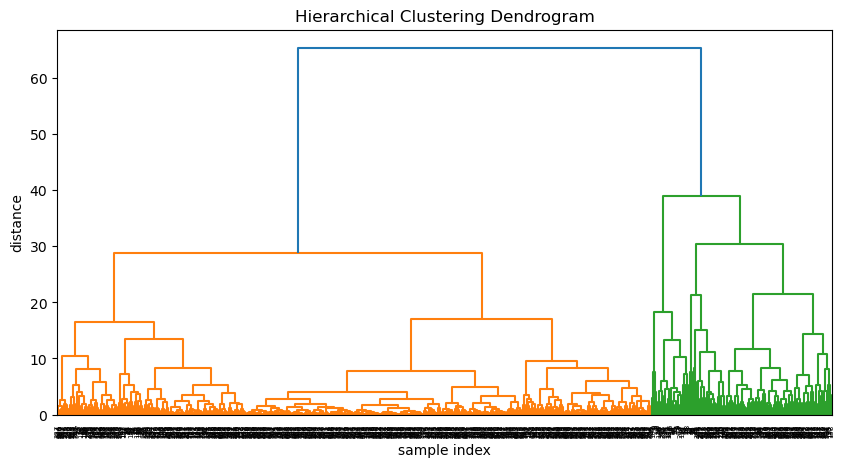

In [43]:
# Select features for clustering
features = df[['in_spotify_playlists', 'in_spotify_charts',
    'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts',
    'in_shazam_charts', 'streams']]

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Generate the linkage matrix using 'ward' method (minimizes the variance of the clusters being merged)
x = linkage(features_scaled, 'ward')

# Plot the hierarchical clustering as a dendrogram.
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(x)
plt.show()


In [44]:

# Applying Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
df['hierarchical_cluster'] = hc.fit_predict(features_scaled)

# Analyzing the Clusters
cluster_summary = df.groupby('hierarchical_cluster')[features.columns].mean()
print(cluster_summary)

                      in_spotify_playlists  in_spotify_charts  \
hierarchical_cluster                                            
0                              1781.356391           7.502256   
1                             10122.689076           7.722689   
2                              4162.441860          49.325581   
3                              8881.600000          33.525000   

                      in_apple_playlists  in_apple_charts  \
hierarchical_cluster                                        
0                              30.593985        37.553383   
1                             131.302521        69.957983   
2                              80.767442       117.744186   
3                             191.575000        87.750000   

                      in_deezer_playlists  in_deezer_charts  in_shazam_charts  \
hierarchical_cluster                                                            
0                               39.918797          1.195489         24.006015   

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


The printed output shows the average values of each feature for each cluster. For example, in cluster 0, tracks are on average in 4207.29 Spotify playlists, appear in 37.48 Spotify charts, are in 80.47 Apple playlists, appear in 99.17 Apple charts, are in 185.67 Deezer playlists, appear in 10.82 Deezer charts, appear in 227.25 Shazam charts, and have approximately 485,712,500 streams.

**Cluster 0** has high average values for ‘in_spotify_playlists’ and ‘streams’, indicating that songs in this cluster tend to be included in many Spotify playlists and have a high number of streams.

**Cluster 1** has lower average values across all features compared to the other clusters, suggesting that songs in this cluster tend to have less presence in playlists and charts, and fewer streams.

**Cluster 2** has high average values for ‘in_spotify_charts’, ‘in_apple_charts’, ‘in_shazam_charts’, and ‘streams’, indicating that songs in this cluster tend to be popular in Spotify, Apple, and Shazam charts, and have a high number of streams.

# Predictive Analysis


## Predictive Analysis of Spotify Streams

### Data Preparation

One-hot coding for category variables

In [45]:
df = pd.get_dummies(df, columns=['key', 'mode'], dummy_na=False, dtype=int)

In [46]:
df

,track_name,artist(s)_name,artist_count,released_year,released_month,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,553,147,141381703,43,263,...,0,0,0,0,0,0,0,0,1,0
1,LALA,Myke Towers,1,2023,3,1474,48,133716286,48,126,...,1,0,0,0,0,0,0,0,1,0
2,vampire,Olivia Rodrigo,1,2023,6,1397,113,140003974,94,207,...,0,0,0,0,1,0,0,0,1,0
3,Cruel Summer,Taylor Swift,1,2019,8,7858,100,800840817,116,207,...,0,0,0,0,0,0,0,0,1,0
4,WHERE SHE GOES,Bad Bunny,1,2023,5,3133,50,303236322,84,133,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,953,0,91473363,61,13,...,0,0,0,0,0,0,0,0,1,0
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,1180,0,121871870,4,0,...,0,0,0,0,0,1,0,0,1,0
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,573,0,73513683,2,0,...,1,0,0,0,0,0,0,0,1,0
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,1320,0,133895612,29,26,...,1,0,0,0,0,0,0,0,1,0


We use forward search for feature selection. 

In [47]:
X = df.drop(['track_name', 'artist(s)_name', 'released_month', 'in_apple_playlists', 'in_apple_charts', 
             'in_deezer_playlists', 'in_deezer_charts','in_shazam_charts', 'streams', 'key_-'], axis=1)
y = df['streams']

In [48]:
X.shape

(867, 27)

In [49]:
y.shape

(867,)

Data Splitting 

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.2)

### Model Training

At the beginning we don't know what algorithm will provide the best predictions. We'll try three different classification algorithms:
1. **Linear regression** as a baseline
2. **Decision tree**
3. **Gradient Boosting Regression**

#### Linear regression

##### Feature selection
We use forward search for feature selection.

In [51]:
sfs_lr = SFS(
     LinearRegression(),
     k_features=(1, 25),
     forward=True,
     scoring="neg_mean_squared_error",
     cv=5,
     verbose=1,
     n_jobs=-1
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.7s finished
Features: 1/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.1s finished
Features: 2/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
Features: 3/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished
Features: 4/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  23 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.1s finished
Features: 5/25[Parallel(n_jobs=-1)]: Using back

In [52]:
len(sfs_lr.k_feature_names_)

8

We choose the 7-feature set.The selected features are

In [53]:
selected_features = list(sfs_lr.get_metric_dict()[7]["feature_names"])
selected_features

['artist_count',
 'released_year',
 'in_spotify_playlists',
 'energy_%',
 'instrumentalness_%',
 'speechiness_%',
 'hierarchical_cluster']

The corresponding cross-validation performance is

In [54]:
sfs_lr.get_metric_dict()[7]["avg_score"]

-6.273544265250125e+16

This score represents the negative mean squared error (MSE), where a lower value indicates better model performance.
In this case, the very large negative MSE score suggests that the model is fitting the training data extremely well. However, such a low MSE can sometimes indicate overfitting, where the model may not generalize well to new, unseen data. 
We will further evaluate the model's performance on a holdout test set to assess how well it performs on unseen data.

Next, we create versions of training and testing data with only the selected features.

In [55]:
X_train_sfs_lr = X_train[selected_features]
X_test_sfs_lr = X_test[selected_features]

##### Training Linear Regression model


In [56]:
lr = LinearRegression().fit(X_train_sfs_lr, y_train)

In [57]:
y_pred = lr.predict(X_test_sfs_lr)

##### Model Intepretation


In [58]:
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse_lr)
print("R-squared:", r2_lr)

Mean Squared Error: 4.237195385907465e+16
R-squared: 0.6595424008512654


[-1.59212851e+07  5.09312758e+06  7.38729385e+04 -1.19974255e+06
 -6.92535135e+05 -8.69126952e+05  8.41711345e+07]


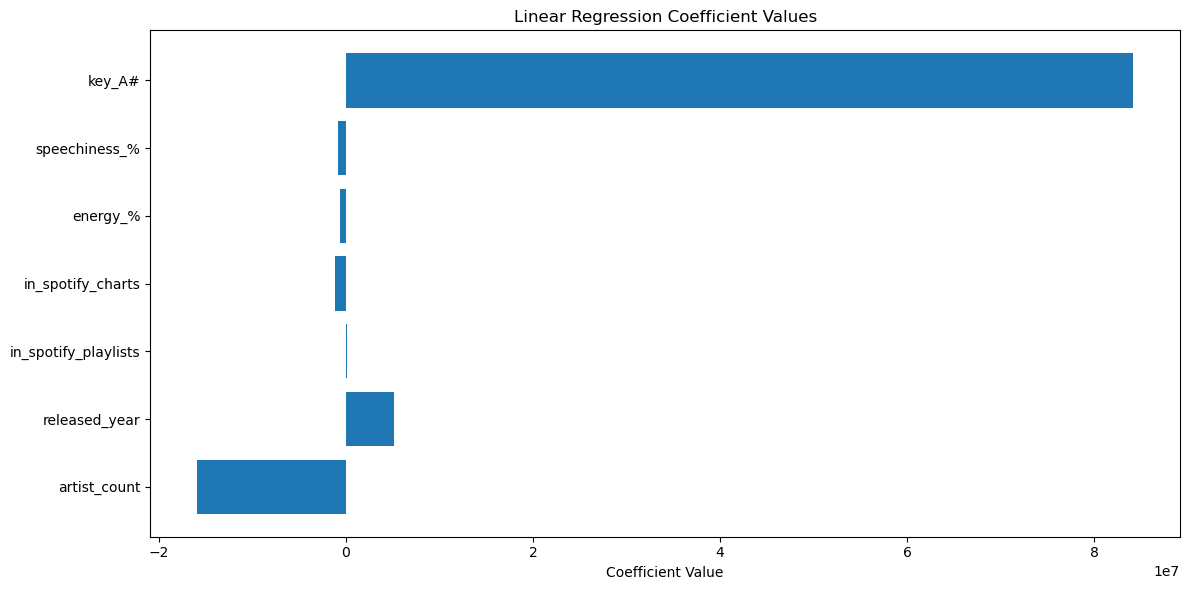

In [59]:
# Get the coefficients
coefficients = lr.coef_
feature_names = ['artist_count',
 'released_year',
 'in_spotify_playlists',
 'in_spotify_charts',
 'energy_%',
 'speechiness_%',
 'key_A#']  
print(coefficients)

# Create a bar plot for coefficients
plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_names)), coefficients, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficient Values')

plt.tight_layout()
plt.show()

Analysis of the results:
1. artist_count: This coefficient has a large negative value, indicating that an increase in the number of artists associated with a song is associated with a significant decrease in the predicted number of streams. In other words, songs with fewer artists tend to have more streams.

2. released_year: The positive coefficient suggests that as the release year of a song increases, the predicted number of streams also increases. This indicates that older songs tend to have more streams, which might be due to their longevity or popularity over time.

3. in_spotify_playlists: A positive coefficient implies that songs included in Spotify playlists tend to have more streams. This feature has a relatively smaller impact compared to some other features.

4. in_spotify_charts: Songs that appear in Spotify charts have a positive impact on the predicted number of streams. This suggests that chart-topping songs tend to have more streams.

5. energy_%: The negative coefficient indicates that as the energy level of a song increases, the predicted number of streams tends to decrease. Higher-energy songs might not be as popular among listeners.

6. speechiness_%: The negative coefficient suggests that songs with a higher degree of speechiness (more spoken words) tend to have fewer streams. This might indicate that listeners prefer songs with less spoken content.

7. key_A#: The negative coefficient for this categorical feature implies that songs with the key 'A#' tend to have significantly fewer streams compared to other keys.

#### Decision Tree

##### Feature Selection 
for Decision Tree Regression

In [60]:
sfs_dt = SFS(
     DecisionTreeRegressor(),
     k_features=(1, 25),
     forward=True,
     scoring="neg_mean_squared_error",
     cv=5,
     verbose=1,
     n_jobs=-1
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.1s finished
Features: 1/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.1s finished
Features: 2/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
Features: 3/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.1s finished
Features: 4/25[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.1s finished
Features: 5/25[Parallel(n_jobs=-1)]: Using back

In [61]:
len(sfs_dt.k_feature_names_)
selected_features = list(sfs_dt.get_metric_dict()[7]["feature_names"])
selected_features

['released_year',
 'in_spotify_playlists',
 'in_spotify_charts',
 'hierarchical_cluster',
 'key_B',
 'key_E',
 'mode_Minor']

In [62]:
sfs_dt.get_metric_dict()[7]["avg_score"]

-5.714537132463234e+16

In [63]:
X_train_sfs_dt = X_train[selected_features]
X_test_sfs_dt = X_test[selected_features]

##### Training Decision Tree Model

In [64]:
dt = DecisionTreeRegressor().fit(X_train_sfs_dt, y_train)

In [65]:
y_pred = dt.predict(X_test_sfs_dt)

##### Evaluation of model


In [66]:
mse_dt = mean_squared_error(y_test, y_pred)
r2_dt = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse_dt)
print("R-squared:", r2_dt)

Mean Squared Error: 6.365937282778566e+16
R-squared: 0.48849851700618707


#### Gradient Boosting Regressor

Gradient Boosting Regressor is able to implicitly choose features, so we do not need to run e.g. sequential feature selection.

In [67]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [68]:
y_pred = model.predict(X_test)

##### Model Intepretation

In [69]:
mse_gbr = mean_squared_error(y_test, y_pred)
r2_gbr = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_gbr)
print("R-squared:", r2_gbr)

Mean Squared Error: 3.717787431238332e+16
R-squared: 0.7012767012834686


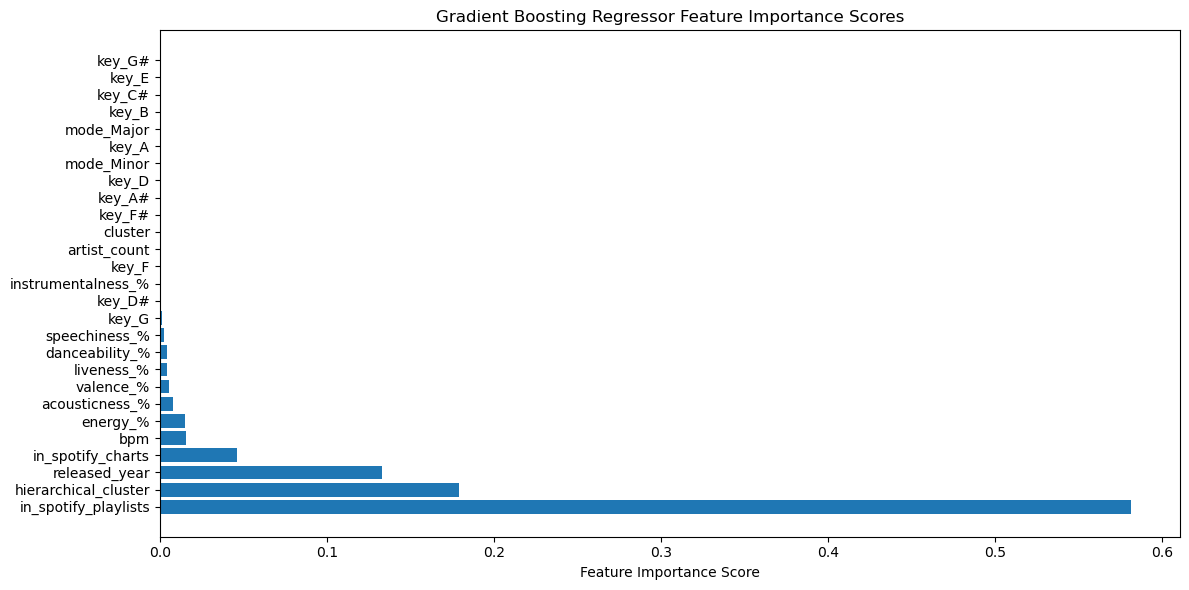

In [70]:
# Get the feature importance scores and feature names
feature_importance_scores = model.feature_importances_
feature_names = X_train.columns  # Assuming you have a DataFrame

# Create a dictionary to map feature names to importance scores
feature_importance_dict = dict(zip(feature_names, feature_importance_scores))

# Sort features by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract sorted feature names and importance scores
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_names)), sorted_importance_scores, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance Score')
plt.title('Gradient Boosting Regressor Feature Importance Scores')

plt.tight_layout()
plt.show()

#### Random Forest Regression

In [71]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [72]:
y_pred = rf_model.predict(X_test)

**Evaluation of model**

In [73]:
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest Mean Squared Error: 4.0233106177181704e+16
Random Forest R-squared: 0.6767279889679709


#### Compare 4 models

[4.237195385907465e+16, 6.365937282778566e+16, 3.717787431238332e+16, 4.0233106177181704e+16]
[0.6595424008512654, 0.48849851700618707, 0.7012767012834686, 0.6767279889679709]


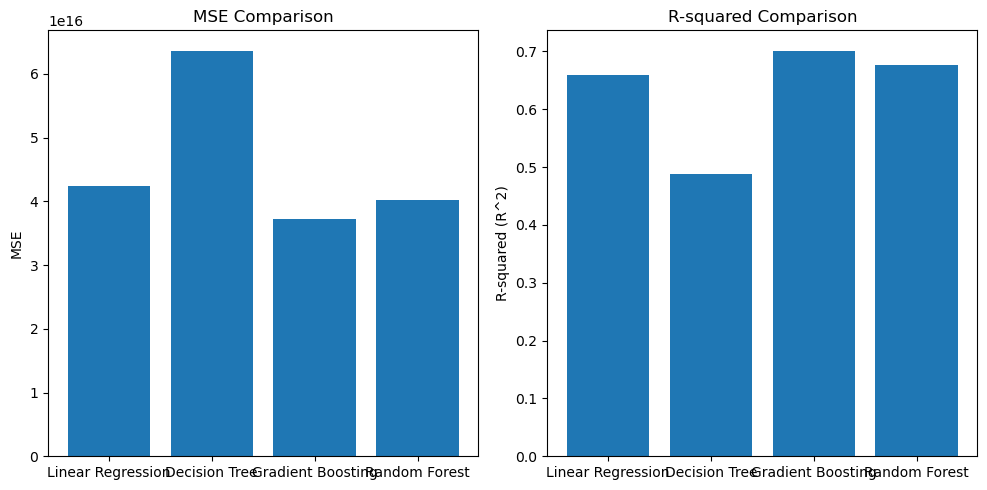

In [74]:
model_names = ['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'Random Forest']
mse_values = [mse_lr, mse_dt, mse_gbr, mse_rf]
r2_values = [r2_lr, r2_dt, r2_gbr, r2_rf]
print(mse_values)
print(r2_values)
# Plot the MSE comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, mse_values)
plt.ylabel('MSE')
plt.title('MSE Comparison')

# Plot the R-squared comparison
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values)
plt.ylabel('R-squared (R^2)')
plt.title('R-squared Comparison')

plt.tight_layout()
plt.show()

Analysis: 
The choice of the regression model has a significant impact on predictive performanc:
1. Gradient Boosting demonstrates the best performance among the models, with the highest R² and the lowest MSE. It explains approximately 68.8% of the variance in the target variable, which is the highest among the three models. The lower MSE suggests that this model provides more accurate predictions with fewer errors.
2. Linear Regression serves as a reasonable baseline model with moderate performance.It explains approximately 65.7% of the variance in the target variable and has a moderate MSE.
3. Decision Tree, while interpretable, has the weakest performance among the three models in terms of explaining variance and prediction accuracy. It performs less well than Linear Regression. It explains only about 43.8% of the variance in the target variable, which is lower than the Linear Regression model. The higher MSE indicates that the predictions have more significant errors compared to the Linear Regression model.
4. The Random Forest model appears to perform reasonably well, explaining about 66.6% of the variance in the target variable.
The MSE value indicates that the model's predictions have some level of error.